## Fraud Detection

Author: Dr.Benjamin Adrian

E-Mail: benjamin.adrian@itwm.fruanhofer.de

In [615]:
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import binom
from scipy.stats import binomtest
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

Example of a modeling of test results of corona test stations.  

In [616]:
inzidenz = 990                   # given incidence
p_i = inzidenz / 100000.0        # resulting probability
number_tests = 10000             # given number of tests

In [617]:
p_if = 800.0 / 100000            # alternative probability of positive test reuslt

Statistical moments of binomial distribution

In [618]:
mean, var, skew, kurt = binom.stats(number_tests, p_i, moments='mvsk')

In [619]:
mean, var, skew, kurt

(array(99.), array(98.0199), array(0.0990051), array(0.00960201))

Generate data

In [6]:
cases_test = []
cases_prob = []
cases_sum = []
cases_test_proportion = []
cases_test_confidence = []
good_stations = 20

positive_counts_good_station = np.array([0 for good_station in range(good_stations)])
positive_counts_fraud_mean_station = np.array([0])
positive_counts_fraud_copy_station = np.array([0])
positive_counts_fraud_fill_station = np.array([0])

for i in range(1, number_tests+1):
    #positive_counts_good_station += [binom.rvs(1, p_i, size=1)[0] for good_station in range(good_stations)]
    positive_counts_good_station += binom.rvs(1, p_i, size=good_stations)
    positive_counts_fraud_zero_station = [0]
    positive_counts_fraud_mean_station += 1 if i%int(1/p_i) == 0 else 0
    positive_counts_fraud_copy_station += binom.rvs(1, p_if, size=1)
    positive_counts_fraud_fill_station += [0] if ((i >=1000 and i <1200) 
                                                or (i >=2000 and i <2200) 
                                                or (i >=3000 and i <3200) 
                                                or (i >=4000 and i <4200)
                                                or (i >=5000 and i <5200)
                                                or (i >=6000 and i <6200)
                                                or (i >=7000 and i <7200)
                                                or (i >=8000 and i <8200)
                                                or (i >=9000 and i <9200)) else binom.rvs(1, p_i, size=1)

    cases_test.append([i] + 
                      [binomtest(positive_counts_good_station[s], i, p=p_i, alternative='less').pvalue for s in range(good_stations)] +
                       [binomtest(positive_counts_fraud_mean_station[0], i, p=p_i, alternative='less').pvalue] +
                       [binomtest(positive_counts_fraud_copy_station[0], i, p=p_i, alternative='less').pvalue] +
                       [binomtest(positive_counts_fraud_fill_station[0], i, p=p_i, alternative='less').pvalue] +
                       [binomtest(0, i, p=p_i).pvalue]
                     )
    cases_test_proportion.append([i] + 
                      [binomtest(positive_counts_good_station[s], i, p=p_i, alternative='less').proportion_estimate for s in range(good_stations)] +
                       [binomtest(positive_counts_fraud_mean_station[0], i, p=p_i, alternative='less').proportion_estimate] +
                       [binomtest(positive_counts_fraud_copy_station[0], i, p=p_i, alternative='less').proportion_estimate] +
                       [binomtest(positive_counts_fraud_fill_station[0], i, p=p_i, alternative='less').proportion_estimate] +          
                       [binomtest(0, i, p=p_i).proportion_estimate]
                     )
    cases_test_confidence.append([i] + 
                      [binomtest(positive_counts_good_station[s], i, p=p_i, alternative='less').proportion_ci(0.95).high for s in range(good_stations)] +
                      [binomtest(positive_counts_fraud_mean_station[0], i, p=p_i, alternative='less').proportion_ci(0.95).high] +
                      [binomtest(positive_counts_fraud_copy_station[0], i, p=p_i, alternative='less').proportion_ci(0.95).high] +
                      [binomtest(positive_counts_fraud_fill_station[0], i, p=p_i, alternative='less').proportion_ci(0.95).high] +
                      [binomtest(0, i, p=p_i).proportion_ci(0.95).high]
                     )
    cases_prob.append([i] + 
                      [binom.cdf(positive_counts_good_station[s], i, p=p_i) for s in range(good_stations)] +
                       [binom.cdf(positive_counts_fraud_mean_station[0], i, p=p_i)] +
                       [binom.cdf(positive_counts_fraud_copy_station[0], i, p=p_i)] +
                       [binom.cdf(positive_counts_fraud_fill_station[0], i, p=p_i)] +
                       [binom.cdf(0, i, p=p_i)]
                     )
    cases_sum.append([i] + positive_counts_good_station.tolist() + 
                           positive_counts_fraud_mean_station.tolist() + 
                           positive_counts_fraud_copy_station.tolist() + 
                           positive_counts_fraud_fill_station.tolist() +
                           positive_counts_fraud_zero_station)

Generate Pandas DataFrames

In [7]:
df_test = pd.DataFrame(cases_test, columns=["number_tests"]+ np.arange(good_stations).tolist() +["f", "fc","ff", "f*"]).set_index("number_tests")
df_test_proportion = pd.DataFrame(cases_test_proportion, columns=["number_tests"]+ np.arange(good_stations).tolist() +["f", "fc","ff", "f*"]).set_index("number_tests")
df_test_confidence = pd.DataFrame(cases_test_confidence, columns=["number_tests"]+ np.arange(good_stations).tolist() +["f", "fc","ff", "f*"]).set_index("number_tests")
df_prob = pd.DataFrame(cases_prob, columns=["number_tests"]+ np.arange(good_stations).tolist() +["f", "fc","ff", "f*"]).set_index("number_tests")
df_sum  = pd.DataFrame(cases_sum,  columns=["number_tests"]+ np.arange(good_stations).tolist() +["f", "fc","ff", "f*"]).set_index("number_tests")

Plot random walks of positive test result over time

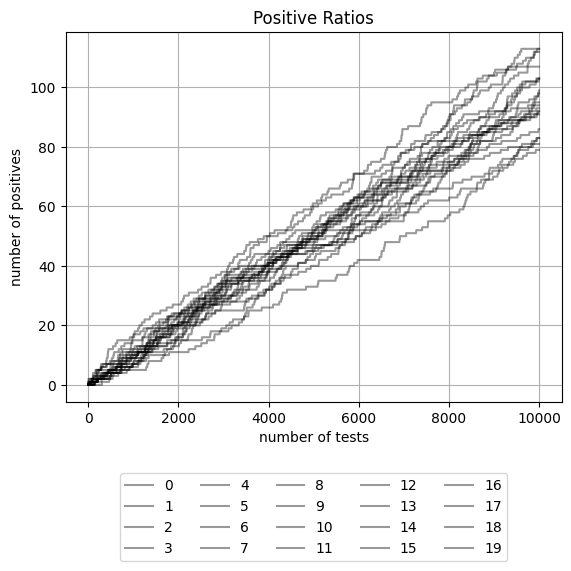

In [10]:
ax0 = df_sum[np.arange(good_stations).tolist()].plot(title="Positive Ratios", alpha=0.4, c="k")
ax0.legend(np.arange(good_stations).tolist(),loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=5,)
ax0.set_xlabel("number of tests")
ax0.set_ylabel("number of positives")
ax0.grid()


### Descriptive Anaytics

#### Plot Z-Scores on random walks

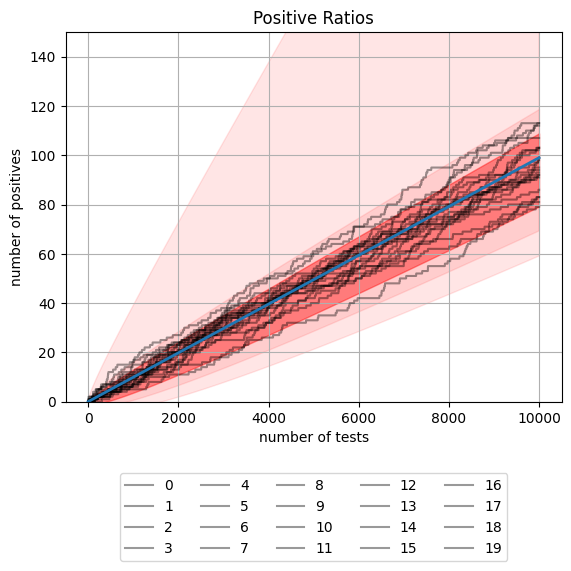

In [15]:
ax0 = df_sum[np.arange(good_stations).tolist()].plot(title="Positive Ratios", alpha=0.4, c="k")
ax0.legend(np.arange(good_stations).tolist(),loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=5,)
ax0.set_xlabel("number of tests")
ax0.set_ylabel("number of positives")
ax0.grid()

line = np.array([binom.stats(i, p_i, moments='m') for i in range(number_tests)])
line_deviation = [binom.stats(i, p_i, moments='v') for i in range(number_tests)]
under_line = (line - 2*np.sqrt(line_deviation))
over_line = (line + 2*np.sqrt(line_deviation))
ax0.set_ylim(0,150)
ax0.plot(line, linewidth=2)
ax0.fill_between(np.arange(number_tests), line - np.sqrt(line_deviation)*3,
                  (line + np.sqrt(line_deviation))*3, color='red', alpha=.1)
ax0.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation)*2,
                  line + np.sqrt(line_deviation)*2, color='red', alpha=.1)
ax0.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation),
                  line + np.sqrt(line_deviation), color='red', alpha=.4)
plt.show()

Plot random walks of fraud station within Z-Scores 

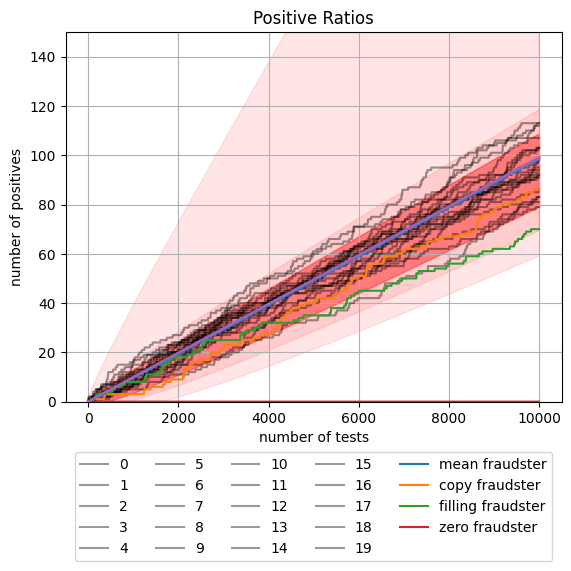

In [16]:
ax0 = df_sum[np.arange(good_stations).tolist()].plot(title="Positive Ratios", alpha=0.4, c="k")
ax0 = df_sum["f"].plot()
ax0 = df_sum["fc"].plot()
ax0 = df_sum["ff"].plot()
ax0 = df_sum["f*"].plot()
ax0.legend(np.arange(good_stations).tolist()+["mean fraudster", "copy fraudster", "filling fraudster", "zero fraudster", "p=0.05"],loc='lower center', 
    bbox_to_anchor=(0.5, -0.45), ncol=5,)
ax0.set_xlabel("number of tests")
ax0.set_ylabel("number of positives")
ax0.grid()

line = np.array([binom.stats(i, p_i, moments='m') for i in range(number_tests)])
line_deviation = [binom.stats(i, p_i, moments='v') for i in range(number_tests)]
under_line = (line - 2*np.sqrt(line_deviation))
over_line = (line + 2*np.sqrt(line_deviation))
ax0.set_ylim(0,150)
ax0.plot(line, linewidth=2)
ax0.fill_between(np.arange(number_tests), line - np.sqrt(line_deviation)*3,
                  (line + np.sqrt(line_deviation))*3, color='red', alpha=.1)
ax0.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation)*2,
                  line + np.sqrt(line_deviation)*2, color='red', alpha=.1)
ax0.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation),
                  line + np.sqrt(line_deviation), color='red', alpha=.4)
plt.show()

#### Cumulated probaliity 

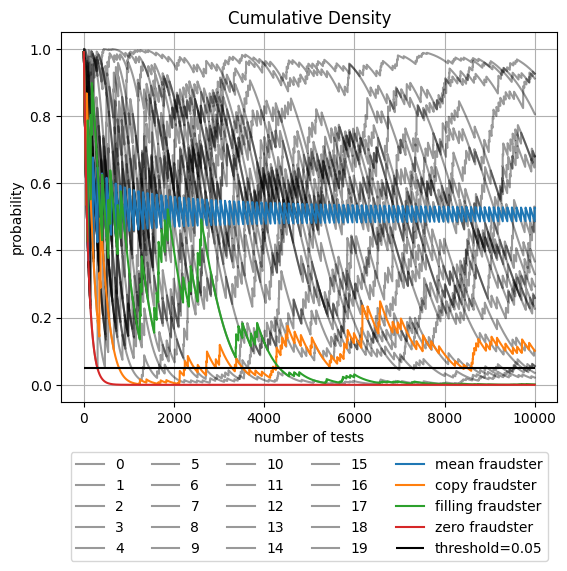

In [18]:
ax2 = df_prob[np.arange(good_stations).tolist()].plot(title="Cumulative Density", alpha=0.4, c="k")
ax2 = df_prob["f"].plot()
ax2 = df_prob["fc"].plot()
ax2 = df_prob["ff"].plot()
ax2 = df_prob["f*"].plot()
ax2.hlines(0.05, 0, number_tests, color="k", label="0.05")
ax2.legend(np.arange(good_stations).tolist()+["mean fraudster", "copy fraudster", "filling fraudster", "zero fraudster", "threshold=0.05"],loc='lower center', 
    bbox_to_anchor=(0.5, -0.45), ncol=5,)
ax2.set_xlabel("number of tests")
ax2.set_ylabel("probability")
ax2.grid()

#### Test proportions

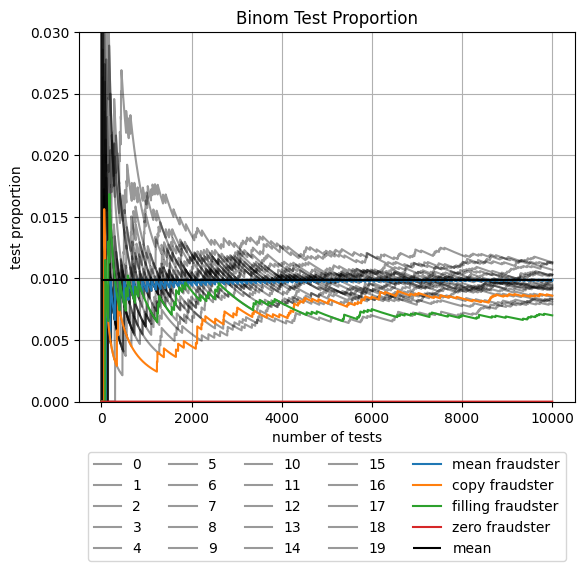

In [21]:
ax11 = df_test_proportion[np.arange(good_stations).tolist()].plot(title="Binom Test Proportion", alpha=0.4, c="k")
ax11 = df_test_proportion["f"].plot()
ax11 = df_test_proportion["fc"].plot()
ax11 = df_test_proportion["ff"].plot()
ax11 = df_test_proportion["f*"].plot()
ax11.hlines(p_i, 0, number_tests, color="k", label="mean")
ax11.legend(np.arange(good_stations).tolist()+["mean fraudster", "copy fraudster", "filling fraudster", "zero fraudster", "mean"],loc='lower center', 
    bbox_to_anchor=(0.5, -0.45), ncol=5,)
ax11.set_xlabel("number of tests")
ax11.set_ylabel("test proportion")
ax11.set_ylim(0,0.03)
ax11.grid()

#### Analyse stationarity
plot first differentiation of a random walk

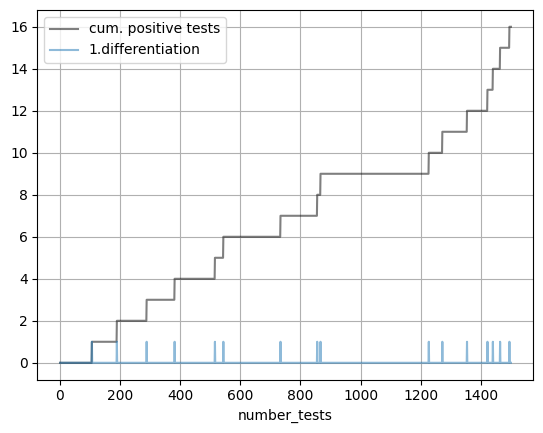

In [620]:
ax11 = df_sum[0].iloc[0:1500].plot(alpha=0.5, label="cum. positive tests", color="k")
ax11 = df_sum[0].iloc[0:1500].diff().plot(alpha=0.5, label="1.differentiation")
plt.grid()
plt.legend()

plot first differentiation of multiple random walk

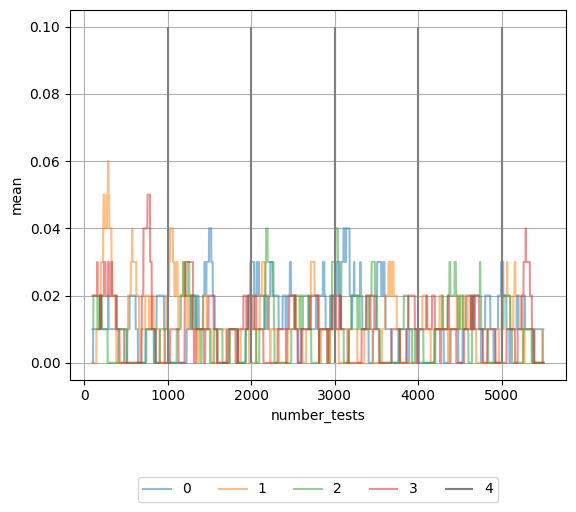

In [623]:
ax11 = df_sum[np.arange(4)].loc[0:5500].diff().rolling(100).mean().plot(alpha=0.5)
plt.vlines([1000,2000,3000,4000,5000], ymin=0, ymax=0.1,color="gray")
plt.legend(["0","1","2","3","4"],loc='lower center', 
    bbox_to_anchor=(0.5, -0.35), ncol=5)
plt.grid()
plt.ylabel("mean")
plt.show()

plot moving variance of first differentiation of a random walk

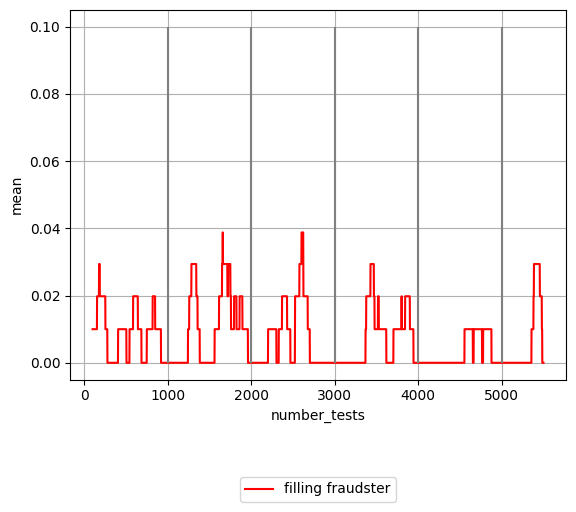

In [624]:
ax11 = df_sum["ff"].loc[1:5500].diff().rolling(100).var().plot(color="r")
plt.legend(["filling fraudster"],loc='lower center', 
    bbox_to_anchor=(0.5, -0.35), ncol=5,)
plt.vlines([1000,2000,3000,4000,5000], ymin=0, ymax=0.1,color="gray")
plt.ylabel("mean")
plt.grid()
plt.show()

#### Feature construction

In [614]:
def count_zero_series(df):
    """ 
    Computes features of series of zero values.
    @param df: Dataframe with differentiated values.
    @return: Series of zero-series-length distribution 
    """
    old = 0
    count = 0
    
    counts = []
    
    for i in df:
        if i == old:
            count +=1
        else:
            if count > 0:
                counts += [count]
            count = 0
    if count > 0:
        counts += [count]
    return pd.Series(counts)

Plot constructed features of zero series length

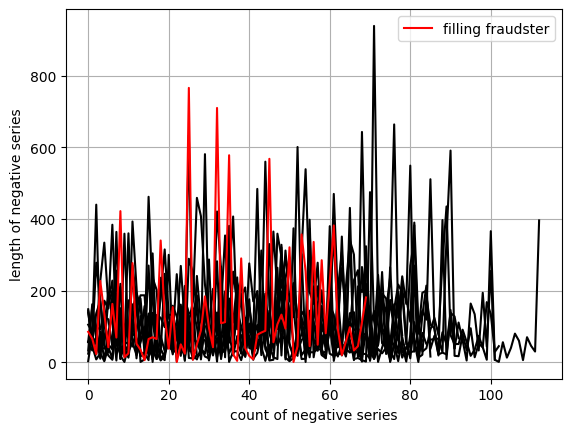

In [625]:
for i in range(10):
    count_zero_series(df_sum[i].diff()).plot(color="k")
count_zero_series(df_sum["ff"].diff()).plot(color="r", label="filling fraudster")
plt.grid()
plt.xlabel("count of negative series")
plt.ylabel("length of negative series")
plt.legend()

Plot series count and median series length

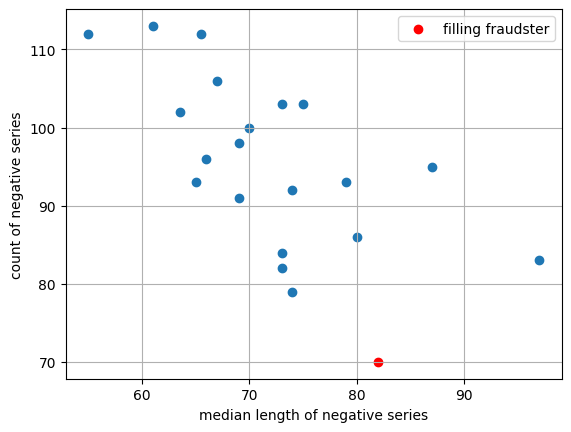

In [626]:
x=[count_zero_series(df_sum[i].diff()).median() for i in range(20)]
y=[count_zero_series(df_sum[i].diff()).count() for i in range(20)]


plt.scatter(x,y)
plt.scatter(count_zero_series(df_sum["ff"].diff()).median(),count_zero_series(df_sum["ff"].diff()).count(), label="filling fraudster", color="red")

plt.grid()
plt.xlabel("median length of negative series")
plt.ylabel("count of negative series")
plt.legend()

Plot series count and mean series length

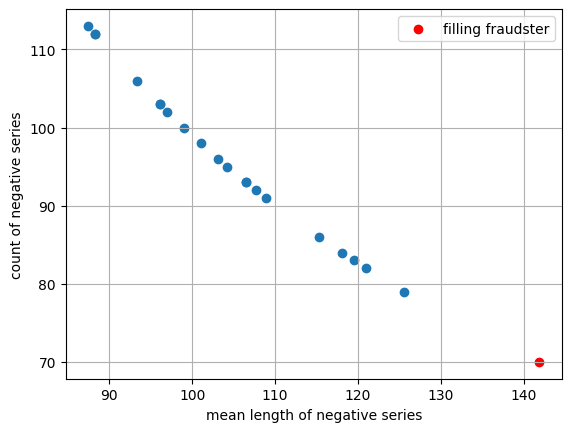

In [627]:
x=[count_zero_series(df_sum[i].diff()).mean() for i in range(20)]
y=[count_zero_series(df_sum[i].diff()).count() for i in range(20)]


plt.scatter(x,y)
plt.scatter(count_zero_series(df_sum["ff"].diff()).mean(),count_zero_series(df_sum["ff"].diff()).count(), label="filling fraudster", color="red")
plt.grid()
plt.xlabel("mean length of negative series")
plt.ylabel("count of negative series")
plt.legend()

In [639]:
a = np.random.binomial(n = number_tests, p = p_i, size = number_tests)

#### Distribution density

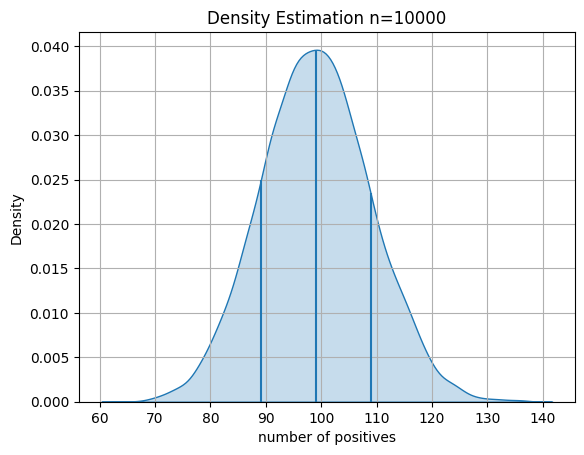

In [655]:
sns.kdeplot(a, fill=True)
plt.grid()
plt.xlabel("number of positives")
plt.title(f"Density Estimation n={number_tests}")
plt.vlines(mean,ymin=0,ymax=0.0395)
plt.vlines(mean-np.sqrt(var),ymin=0,ymax=0.025)
plt.vlines(mean+np.sqrt(var),ymin=0,ymax=0.0235)
plt.show()

Plot the cumulated distribution density

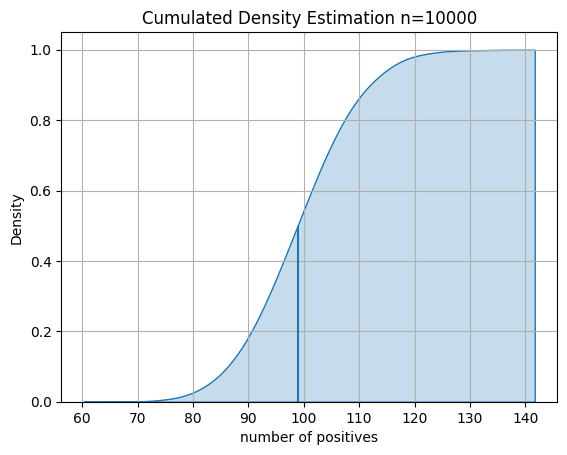

In [658]:
sns.kdeplot(a, fill=True, cumulative=True)
plt.grid()
plt.xlabel("number of positives")
plt.title(f"Cumulated Density Estimation n={number_tests}")
plt.vlines(mean,ymin=0,ymax=0.5)
plt.show()

#### Benford

plot the histogram of the first digit for log normal distributed numbers.

Text(0, 0.5, 'count')

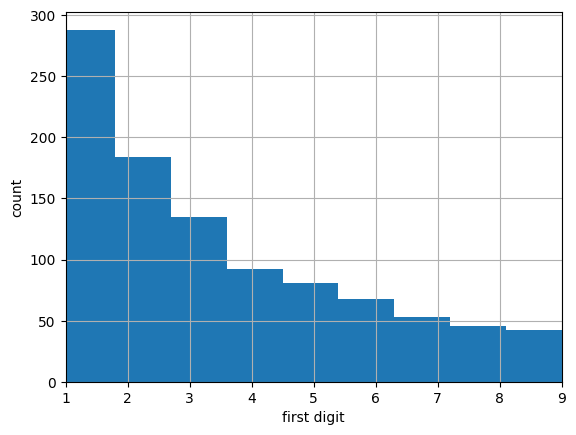

In [234]:
benford = np.sort([s[0] for s in np.array([10**(np.random.normal(0.5,0.5)+np.random.randint(0,20)) for i in range(1000)]).astype(str)])
plt.hist(benford)
plt.xlim(1,9)
plt.grid()
plt.xlabel("first digit")
plt.ylabel("count")

### Predictive Analytics
#### Generate Training Data for predictive analytics

In [387]:
good_stations = 100
fraud_stations = 10

good = np.zeros(good_stations)
fraud = np.zeros(fraud_stations)

cases_good = []
cases_fraud = []

for i in range(1, number_tests+1):
    good += binom.rvs(1, p_i, size=good_stations)
    fraud += [0 if ((i >=1000 and i <1200+10*(fs+1)) 
                    or (i >=2000 and i <2200+10*(fs+1)) 
                    or (i >=3000 and i <3200+10*(fs+1)) 
                    or (i >=4000 and i <4200+10*(fs+1))
                    or (i >=5000 and i <5200+10*(fs+1))
                    or (i >=6000 and i <6200+10*(fs+1))
                    or (i >=7000 and i <7200+10*(fs+1))
                    or (i >=8000 and i <8200+10*(fs+1))
                    or (i >=9000 and i <9200+10*(fs+1))) else binom.rvs(1, p_i, size=1)[0] for fs in range(fraud_stations)]   
    
    cases_good.append([i] + good.tolist())
    cases_fraud.append([i] + fraud.tolist())

In [388]:
df_good  = pd.DataFrame(cases_good,  columns=["number_tests"]+ np.arange(good_stations).tolist()).set_index("number_tests")
df_fraud = pd.DataFrame(cases_fraud,  columns=["number_tests"]+ np.arange(fraud_stations).tolist()).set_index("number_tests")
df_fraud_intensity = [10*(200+10*(fs+1)) for fs in range(fraud_stations)]

In [389]:
df_fraud_intensity

[2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]

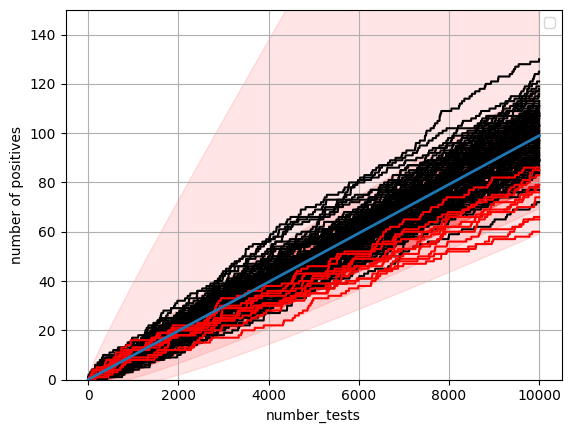

In [551]:
ax =df_good.plot(color="k")
df_fraud.plot(color="r", ax=ax)
plt.legend([])
plt.grid()

plt.ylabel("number of positives")

line = np.array([binom.stats(i, p_i, moments='m') for i in range(number_tests)])
line_deviation = [binom.stats(i, p_i, moments='v') for i in range(number_tests)]
under_line = (line - 2*np.sqrt(line_deviation))
over_line = (line + 2*np.sqrt(line_deviation))

plt.ylim(0,150)
plt.plot(line, linewidth=2)
plt.fill_between(np.arange(number_tests), line - np.sqrt(line_deviation)*3,
                  (line + np.sqrt(line_deviation))*3, color='red', alpha=.1)
plt.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation)*2,
                  line + np.sqrt(line_deviation)*2, color='red', alpha=.1)
plt.fill_between(np.arange(number_tests), line - 2*np.sqrt(line_deviation),
                  line + np.sqrt(line_deviation), color='red', alpha=.4)

#### Setting up regression

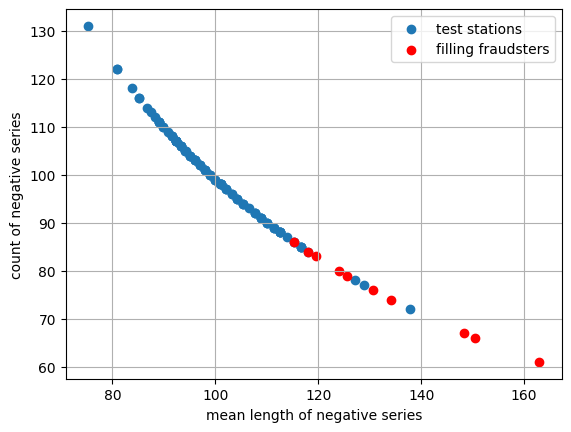

In [553]:
end=10000

x_good=[count_zero_series(df_good[i].iloc[0:end].diff()).mean() for i in range(good_stations)]
y_good=[count_zero_series(df_good[i].iloc[0:end].diff()).count() for i in range(good_stations)]

x_fraud=[count_zero_series(df_fraud[i].iloc[0:end].diff()).mean() for i in range(fraud_stations)]
y_fraud=[count_zero_series(df_fraud[i].iloc[0:end].diff()).count() for i in range(fraud_stations)]



plt.scatter(x_good,y_good, label="test stations")
plt.scatter(x_fraud,y_fraud, label="filling fraudsters", color="red")


#plt.scatter(count_zero_series(df_sum["fc"].diff()).mean(),count_zero_series(df_sum["fc"].diff()).count())
#plt.scatter(count_zero_series(df_sum["f"].diff()).mean(),count_zero_series(df_sum["f"].diff()).count())
plt.grid()
plt.xlabel("mean length of negative series")
plt.ylabel("count of negative series")
plt.legend()
#print(count_zero_series(df_sum["ff"].diff()).mean())
#print(count_zero_series(df_sum["fc"].diff()).mean())
#print(count_zero_series(df_sum["f"].diff()).mean())
#print(count_zero_series(df_sum["f*"].diff()).mean())

Evauating features

In [562]:
pd.DataFrame(np.array([x_fraud, y_fraud, df_fraud_intensity]).T, columns=["mean length","count","loss"]).corr()

,mean length,count,loss
mean length,1.000000,-0.995811,0.297328
count,-0.995811,1.000000,-0.272812
loss,0.297328,-0.272812,1.000000


In [563]:
pd.DataFrame(np.array([x_good, y_good]).T, columns=["mean length","count"]).corr()

,mean length,count
mean length,1.000000,-0.988359
count,-0.988359,1.000000


Coefficients: 
 [5.63072544]
Intercept: 
 1801.8262927488956


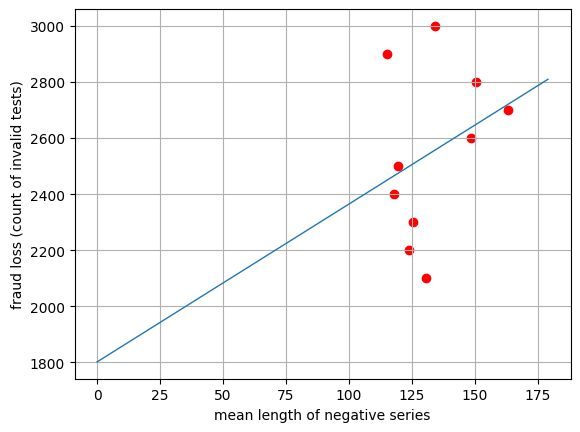

In [565]:
# Create linear regression object
regr = linear_model.LinearRegression()

x=np.array([x_fraud]).T
y=df_fraud_intensity

# Train the model using the training sets
regr.fit(x,y)

# Make predictions using the testing set
y_pred = regr.predict(np.array([x_good]).T)

print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)

# Plot outputs
plt.scatter(x_fraud, df_fraud_intensity, color="red", label="fraudsters")
plt.plot([regr.intercept_ + i*regr.coef_ for i in range(180)], linewidth=1)
plt.xlabel("mean length of negative series")
plt.ylabel("fraud loss (count of invalid tests)")
plt.grid()
plt.show()

Setup inverse regression x over Y

Coefficients: 
 [0.01570028]
Intercept: 
 92.83769440256273


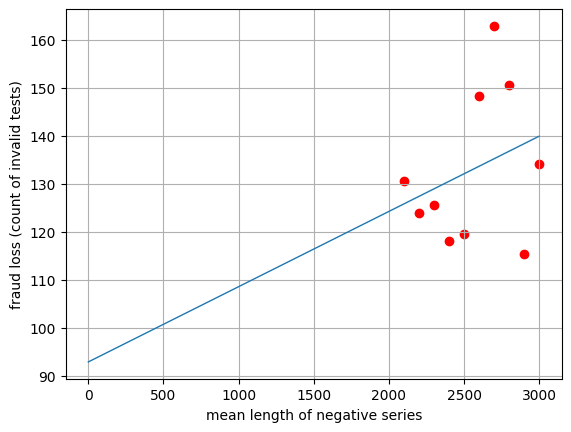

In [564]:
regr_inv = linear_model.LinearRegression()

x=x_fraud
y=np.array([df_fraud_intensity]).T

# Train the model using the training sets
regr_inv.fit(y,x)

print("Coefficients: \n", regr_inv.coef_)
print("Intercept: \n", regr_inv.intercept_)

plt.scatter(df_fraud_intensity, x_fraud, color="red", label="fraudsters")
plt.plot([regr_inv.intercept_ + i*regr_inv.coef_ for i in range(3000)], linewidth=1)
plt.xlabel("mean length of negative series")
plt.ylabel("fraud loss (count of invalid tests)")
plt.grid()
plt.show()

In [727]:
print("Coefficients: \n", regr.coef_)
print("Intercept: \n", regr.intercept_)

print("Coefficients: \n", regr_inv.coef_)
print("Intercept: \n", regr_inv.intercept_)

Coefficients: 
 [5.63072544]
Intercept: 
 1801.8262927488956
Coefficients: 
 [0.01570028]
Intercept: 
 92.83769440256273


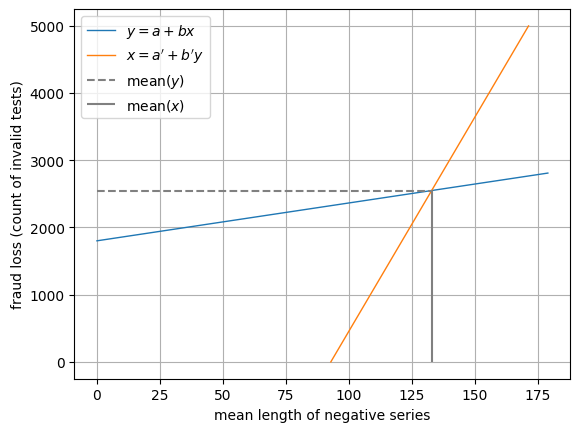

In [723]:
x = range(180)
x_inv = range(5000)
y_reg = [regr.intercept_ + i*regr.coef_ for i in x]
y_inv_reg = [regr_inv.intercept_ + i*regr_inv.coef_ for i in x_inv]
plt.plot(x, y_reg, linewidth=1, label="$y=a+bx$")
plt.plot(y_inv_reg,x_inv, linewidth=1, label="$x=a'+b'y$")

plt.hlines(np.mean(df_fraud_intensity),0,np.mean(x_fraud), color="gray", linestyle="--", label="mean$(y)$")
plt.vlines(np.mean(x_fraud),0,np.mean(df_fraud_intensity), color="gray", linestyle="-", label="mean$(x)$")


plt.grid()
plt.xlabel("mean length of negative series")
plt.ylabel("fraud loss (count of invalid tests)")
plt.legend()
plt.show()

#### Setup classification
Visualise a logistic function

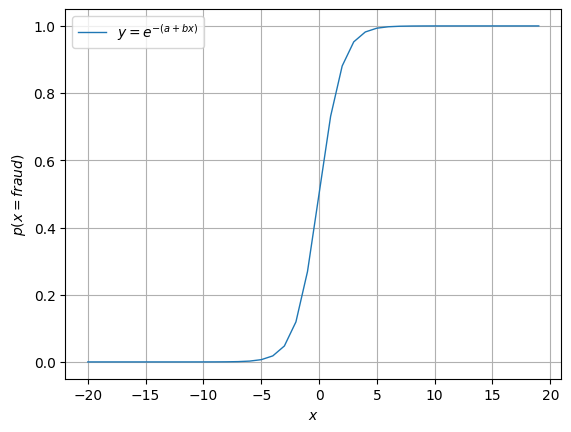

In [726]:
x = range(-20,20)
y_reg = [1/(1+np.exp(-i)) for i in x]
plt.plot(x, y_reg, linewidth=1, label="$y=e^{-(a+bx)}$")

plt.grid()
plt.xlabel("$x$")
plt.ylabel("$p(x=fraud)$")
plt.legend()
plt.show()

In [724]:
x=np.concatenate([np.array([x_fraud, y_fraud]).T, np.array([x_good[:50], y_good[:50]]).T])
y=np.concatenate([np.ones(len(y_fraud)), np.zeros(len(y_good[:50]))])

clf = LogisticRegression(random_state=0).fit(x, y)

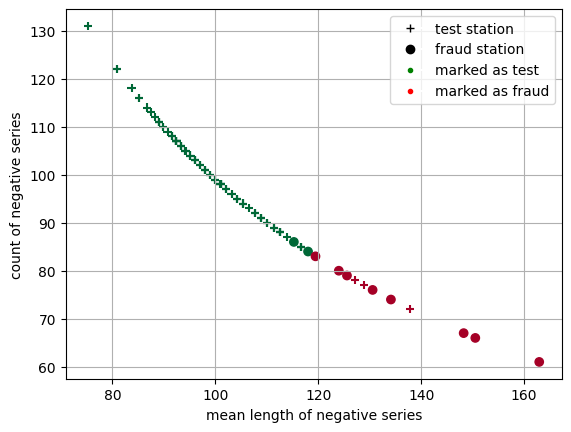

In [725]:
end=10000


x_good=[count_zero_series(df_good[i].iloc[0:end].diff()).mean() for i in range(good_stations)]
y_good=[count_zero_series(df_good[i].iloc[0:end].diff()).count() for i in range(good_stations)]

x_fraud=[count_zero_series(df_fraud[i].iloc[0:end].diff()).mean() for i in range(fraud_stations)]
y_fraud=[count_zero_series(df_fraud[i].iloc[0:end].diff()).count() for i in range(fraud_stations)]



plt.scatter(np.array(x_good),np.array(y_good), label="test stations", c=clf.predict(np.array([x_good[:], y_good[:]]).T), marker="+", cmap='RdYlGn_r')
plt.scatter(np.array(x_fraud),np.array(y_fraud), label="filling fraudsters", c=clf.predict(np.array([x_fraud[:], y_fraud[:]]).T), marker="o",cmap='RdYlGn_r')


plt.grid()
plt.xlabel("mean length of negative series")
plt.ylabel("count of negative series")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='+', color='w', label='test station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='.', color='w', label='marked as test',markerfacecolor='g', markeredgecolor='g'),
    Line2D([0], [0], marker='.', color='w', label='marked as fraud',markerfacecolor='r', markeredgecolor='r')]
plt.legend(handles=legend_elements)


#### Putting regression and classification together

(0.0, 120.0)

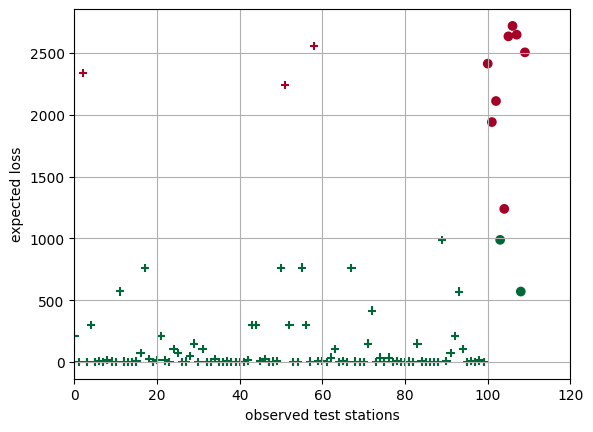

In [613]:
plt.scatter(range(100), clf.predict_proba(np.array([x_good[:], y_good[:]]).T)[:,1] * regr.predict(np.array([x_good]).T), c= clf.predict(np.array([x_good[:], y_good[:]]).T), cmap='RdYlGn_r',marker="+")
plt.scatter(range(100,110), clf.predict_proba(np.array([x_fraud[:], y_fraud[:]]).T)[:,1] * regr.predict(np.array([x_fraud]).T), c= clf.predict(np.array([x_fraud[:], y_fraud[:]]).T), cmap='RdYlGn_r',  marker="o")
plt.grid()
plt.ylabel("expected loss")
plt.xlabel("observed test stations")
plt.xlim(0,120)

#### Logistic Function

In [675]:
fraud_test = np.zeros(fraud_stations)

cases_fraud_test = []

for i in range(1, number_tests+1):
    fraud_test += [0 if ((i >=1000 and i <1200+15*(fs+1)) 
                    or (i >=2000 and i <2200+15*(fs+1)) 
                    or (i >=3000 and i <3200+15*(fs+1)) 
                    or (i >=4000 and i <4200+15*(fs+1))
                    or (i >=5000 and i <5200+15*(fs+1))
                    or (i >=6000 and i <6200+15*(fs+1))
                    or (i >=7000 and i <7200+15*(fs+1))
                    or (i >=8000 and i <8200+15*(fs+1))
                    or (i >=9000 and i <9200+15*(fs+1))) else binom.rvs(1, p_i, size=1)[0] for fs in range(fraud_stations)]   
    

    cases_fraud_test.append([i] + fraud_test.tolist())

#### Testing the models

In [676]:
df_fraud_test = pd.DataFrame(cases_fraud_test,  columns=["number_tests"]+ np.arange(fraud_stations).tolist()).set_index("number_tests")
df_fraud_intensity_test = [10*(200+11*(fs+1)) for fs in range(fraud_stations)]

In [677]:
x_fraud_test=[count_zero_series(df_fraud_test[i].iloc[0:end].diff()).mean() for i in range(fraud_stations)]
y_fraud_test=[count_zero_series(df_fraud_test[i].iloc[0:end].diff()).count() for i in range(fraud_stations)]

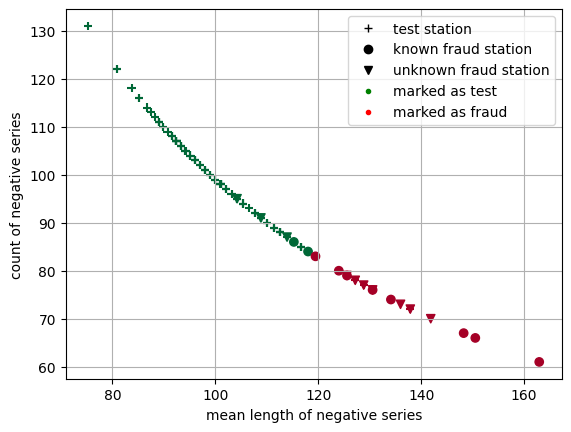

In [714]:
plt.scatter(np.array(x_good),np.array(y_good), c=clf.predict(np.array([x_good[:], y_good[:]]).T), marker="+", cmap='RdYlGn_r')
plt.scatter(np.array(x_fraud_test),np.array(y_fraud_test), c=clf.predict(np.array([x_fraud_test[:], y_fraud_test[:]]).T), marker="v",cmap='RdYlGn_r')
plt.scatter(np.array(x_fraud),np.array(y_fraud), c=clf.predict(np.array([x_fraud[:], y_fraud[:]]).T), marker="o",cmap='RdYlGn_r')


plt.grid()
plt.xlabel("mean length of negative series")
plt.ylabel("count of negative series")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='+', color='w', label='test station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='known fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='v', color='w', label='unknown fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='.', color='w', label='marked as test',markerfacecolor='g', markeredgecolor='g'),
    Line2D([0], [0], marker='.', color='w', label='marked as fraud',markerfacecolor='r', markeredgecolor='r')]
plt.legend(handles=legend_elements)

In [705]:
np.sqrt(np.mean(np.power(df_fraud_intensity - regr.predict(np.array([x_fraud[:]]).T),2)))

274.2383488289903

In [704]:
np.sqrt(np.mean(np.power(df_fraud_intensity_test - regr.predict(np.array([x_fraud_test[:]]).T),2)))

299.7109965177303

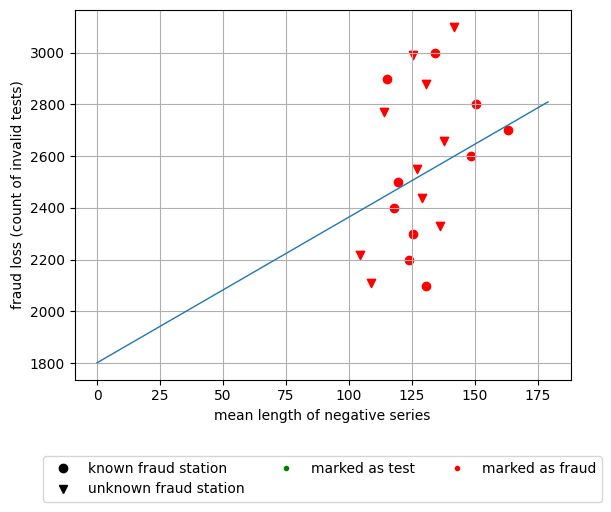

In [710]:
plt.scatter(x_fraud_test, df_fraud_intensity_test, color="red", label="unknown fraudsters", marker="v")
plt.scatter(x_fraud, df_fraud_intensity, color="red", label="known fraudsters", marker="o")
plt.plot([regr.intercept_ + i*regr.coef_ for i in range(180)], linewidth=1)
plt.xlabel("mean length of negative series")
plt.ylabel("fraud loss (count of invalid tests)")
plt.grid()
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='known fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='v', color='w', label='unknown fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='.', color='w', label='marked as test',markerfacecolor='g', markeredgecolor='g'),
    Line2D([0], [0], marker='.', color='w', label='marked as fraud',markerfacecolor='r', markeredgecolor='r')]
plt.legend(handles=legend_elements,loc='lower center', 
    bbox_to_anchor=(0.5, -0.35), ncol=3,)
plt.show()

In [719]:
clf.score(np.array([x_good[:], y_good[:]]).T, np.zeros(100))

0.97

In [720]:
clf.score(np.array([x_fraud_test[:], y_fraud_test[:]]).T, np.ones(10))

0.7

In [721]:
clf.score(np.array([x_fraud[:], y_fraud[:]]).T, np.ones(10))

0.8

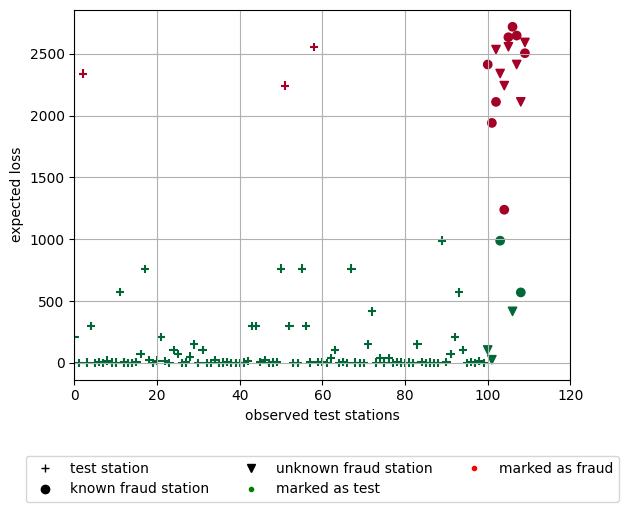

In [709]:
plt.scatter(range(100), clf.predict_proba(np.array([x_good[:], y_good[:]]).T)[:,1] * regr.predict(np.array([x_good]).T), c= clf.predict(np.array([x_good[:], y_good[:]]).T), cmap='RdYlGn_r',marker="+")
plt.scatter(range(100,110), clf.predict_proba(np.array([x_fraud[:], y_fraud[:]]).T)[:,1] * regr.predict(np.array([x_fraud]).T), c= clf.predict(np.array([x_fraud[:], y_fraud[:]]).T), cmap='RdYlGn_r',  marker="o")
plt.scatter(range(100,110), clf.predict_proba(np.array([x_fraud_test[:], y_fraud_test[:]]).T)[:,1] * regr.predict(np.array([x_fraud_test]).T), c= clf.predict(np.array([x_fraud_test[:], y_fraud_test[:]]).T), cmap='RdYlGn_r',  marker="v")
plt.grid()
plt.ylabel("expected loss")
plt.xlabel("observed test stations")
plt.xlim(0,120)
legend_elements = [
    Line2D([0], [0], marker='+', color='w', label='test station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='known fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='v', color='w', label='unknown fraud station',markerfacecolor='k', markeredgecolor='k'),
    Line2D([0], [0], marker='.', color='w', label='marked as test',markerfacecolor='g', markeredgecolor='g'),
    Line2D([0], [0], marker='.', color='w', label='marked as fraud',markerfacecolor='r', markeredgecolor='r')]
plt.legend(handles=legend_elements,loc='lower center', 
    bbox_to_anchor=(0.5, -0.35), ncol=3,)